# Определение перспективного тарифа для телеком-компании

## Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов

### Тариф «Смарт»
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
* минута разговора: 3 рубля
* сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей

### Тариф «Ультра»
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
* минута разговора: 1 рубль
* сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей

## Описание данных

**Таблица `users` (информация о пользователях):**
* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tariff` — название тарифного плана

**Таблица `calls` (информация о звонках):**
* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок

**Таблица `messages` (информация о сообщениях):**
* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**
* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**
* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## План работ

[**Шаг 1. Открытие файла с данными и изучение общей информации**](#level1)
<br />
Загрузка и обзор датасетов, проверка корректности названия столбцов и типов данных.

[**Шаг 2. Подготовка данных**](#level2)
<br />
Обработка пропусков, проверка на дубликаты, рассчёты выручки.

[**Шаг 3. Анализ поведения**](#level3)
<br />
Сравнение поведения пользователей в двух тарифах. Обзор звонков, сообщений, трафика, выручки.

[**Шаг 4. Проверка гипотез**](#level4)
<br />
Проверка поставленных гипотез.

In [1]:
# Включаем библиотеки, кот. могут понадобиться

import pandas as pd
import math
import numpy as np
import seaborn as sns
from scipy import stats as st
#import matplotlib.pyplot as plt

### Шаг 1. Открытие файла с данными и изучение общей информации
<a id='level1'></a>

In [2]:
try:
  # Сразу парсим данные
  data_calls = pd.read_csv("calls.csv", parse_dates=['call_date'])
  data_internet = pd.read_csv("internet.csv", parse_dates=['session_date'], index_col=0)
  data_messages = pd.read_csv("messages.csv", parse_dates=['message_date'])
  data_tariffs = pd.read_csv("tariffs.csv")
  data_users = pd.read_csv("users.csv", parse_dates=['reg_date', 'churn_date'])

# Пробуем другой путь, если проект открывается не local
except:
  data_calls = pd.read_csv("/datasets/calls.csv", parse_dates=['call_date'])
  data_internet = pd.read_csv("/datasets/internet.csv", parse_dates=['session_date'], index_col=0)
  data_messages = pd.read_csv("/datasets/messages.csv", parse_dates=['message_date'])
  data_tariffs = pd.read_csv("/datasets/tariffs.csv")
  data_users = pd.read_csv("/datasets/users.csv", parse_dates=['reg_date', 'churn_date'])

# Настройка, чтобы отображались все столбцы при обзоре
pd.options.display.max_columns = 50
# Уберем навязчивые варнинги
pd.options.mode.chained_assignment = None 

# Проверяем подключение файла, осматриваемся
print(data_calls.shape, data_internet.shape, data_messages.shape, data_users.shape, data_tariffs.shape)

(202607, 4) (149396, 4) (123036, 3) (500, 8) (2, 8)


In [3]:
# Сделаем обзор всех датасетов

print('--calls--')
data_calls.info()
print()
print('--internet--')
data_internet.info()
print()
print('--messages--')
data_messages.info()
print()
print('--user--:')
data_users.info()
print()
print('--tariffs--')
data_tariffs.info()

--calls--
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB

--internet--
<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


На вид - пустых значений нет. Везде ровное распределение, кроме `churn_date` в `users`.

Есть проблемы в `internet` - странная неназванная колонка.

Количество строк в таблицах разные и это логично - звонков больше всего.

Посмотрим на данные в каждой таблице:

In [4]:
data_calls.sample(5)

,id,call_date,duration,user_id
178784,1446_69,2018-10-25,0.01,1446
80502,1200_405,2018-06-18,9.25,1200
16007,1044_113,2018-12-17,13.62,1044
72215,1179_487,2018-08-15,10.68,1179
108278,1280_197,2018-10-23,9.91,1280


Колонку с датой мы уже преобразовали при парсинге. Остальные колонки вылядят нормально.

In [5]:
# Диапазон дат

print(data_calls['call_date'].min())
print(data_calls['call_date'].max())

2018-01-01 00:00:00
2018-12-31 00:00:00


In [6]:
data_internet.sample(5)

,id,mb_used,session_date,user_id
46990,1161_10,311.10,2018-09-26,1161
94124,1318_138,0.00,2018-06-22,1318
67664,1228_449,398.24,2018-04-29,1228
5453,1015_461,451.67,2018-09-30,1015
7053,1024_108,428.43,2018-12-12,1024


Посмотрим на аномалии в трафике:

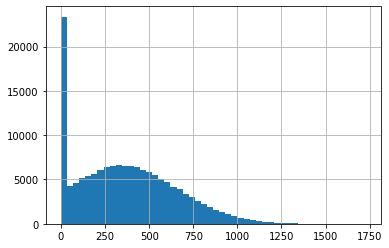

In [7]:
data_internet['mb_used'].hist(bins=50);

Среди нормального распределения есть ноль. Посмотрим на процентное соотношение:

In [8]:
data_internet.query('mb_used == 0').count() / data_internet.count() * 100

id              13.118156
mb_used         13.118156
session_date    13.118156
user_id         13.118156
dtype: float64

13% данных содержит 0 трафика. Значит, в этом месяце трафиком не пользовались.

In [9]:
# Удаляем столбец и проверяем
#data_internet = data_internet.drop(columns='Unnamed: 0')
#data_internet.info()

Здесь всё в порядке. Посмотрим на юзеров:

In [10]:
data_users.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
294,1294,66,NaT,Владивосток,Дебора,Асафьева,2018-02-20,ultra
176,1176,37,NaT,Волгоград,Радим,Куприянов,2018-01-20,smart
72,1072,49,NaT,Уфа,Андрей,Андрейкин,2018-02-20,smart
333,1333,58,NaT,Москва,Вера,Антонова,2018-09-28,ultra
203,1203,39,NaT,Москва,Владимир,Григорьев,2018-03-13,ultra


В `churn_date` есть пропуски, но это не страшно, т.к. абоненты являются ещё клиентами.

In [11]:
# Диапазон дат
print(data_users['reg_date'].min())
print(data_users['reg_date'].max())

2018-01-01 00:00:00
2018-12-31 00:00:00


In [12]:
# Проверим дубликаты и регистры в городах. Уникализируем и сортируем
city = data_users['city'].unique().tolist()
city.sort()

print(city)

['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород', 'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград', 'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург', 'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга', 'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск', 'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва', 'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород', 'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск', 'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск', 'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара', 'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск', 'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь', 'Тольятти', 'Томск', 'Тула', 'Тюмень', 'Улан-Удэ', 'Ульяновск', 'Уфа', 'Хабаровск', 'Химки', 'Чебоксары', 'Челябинск', 'Череповец', 'Чита', 'Якутск', 'Ярославль']


Посмотрим на статистику users, особенно на возраст:

In [13]:
data_users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


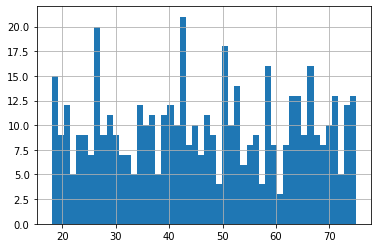

In [14]:
data_users['age'].hist(bins=50);

Пик графика на возрасте 46 лет. Вторая мода на уровне 26-28 лет.

Посмотрим на соотношения тарифов:

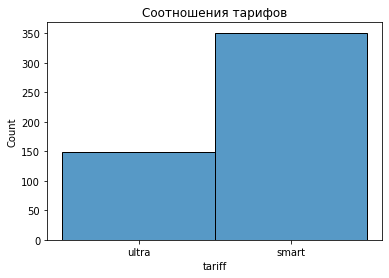

In [15]:
sns.histplot(data=data_users, x="tariff", bins=40).set_title('Соотношения тарифов');

Тарифа smart гораздо больше, что логично - он дешевле.

Посмотрим тарифы:

In [16]:
# Проверим тарифы
data_users['tariff'].unique().tolist()

['ultra', 'smart']

In [17]:
data_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [18]:
# Проверим на пересечение уникальны user_id

#id_calls = data_calls['user_id'].unique()
#id_messages = data_messages['user_id'].unique()

#print(data_messages.query('user_id not in @id_calls')['user_id'].unique())
#print(data_internet.query('user_id not in @id_calls')['user_id'].unique())
#print(data_users.query('user_id not in @id_calls')['user_id'].unique())

#print(data_calls.query('user_id not in @id_messages')['user_id'].unique())

print(set(data_users.user_id) - set(data_calls.user_id))
print(set(data_users.user_id) - set(data_messages.user_id))
print(set(data_users.user_id) - set(data_internet.user_id))

{1473, 1091, 1128, 1231, 1328, 1489, 1106, 1371}
{1024, 1152, 1153, 1157, 1162, 1290, 1291, 1292, 1040, 1297, 1428, 1301, 1429, 1175, 1049, 1177, 1179, 1305, 1053, 1306, 1435, 1185, 1442, 1063, 1322, 1195, 1456, 1201, 1204, 1078, 1334, 1208, 1462, 1210, 1339, 1466, 1085, 1469, 1220, 1095, 1224, 1225, 1479, 1228, 1101, 1360, 1107, 1363, 1494, 1367, 1240, 1114, 1242, 1116, 1117, 1118, 1370, 1120, 1248, 1371, 1376, 1254, 1255, 1128, 1001, 1129, 1132, 1260, 1006, 1388, 1010, 1397, 1143, 1017}
{1128, 1273, 1371}


Есть user_id, которых нет в других таблицах, но я не вижу ничего страшного. Объединение происходит методом outer, поэтому все user_id попадут в итоговую таблицу. А недостающие поля буду заполнены нулями.

**Выводы:**

* Пустых значений нет. Везде ровное распределение, кроме churn_date в users, но там пропуски умышленные.
* Были проблемы в internet - странная неназванная колонка, которую удалили.
* Количество строк в датасетах разные и это логично - звонков больше всего.
* Тип колонки с датой преобразованы при парсинге. Остальные типы колонок вылядят нормально.
* Категориальная колонка city не дублируются, регистр в норме.
* Возраст пользователей начинается с 18 лет. Основной возраст - от 18 до 62 лет. Пик графика на возрасте 46 лет. Вторая мода на уровне 26-28 лет.
Самому старому клиенту 75 лет.
* 13% данных содержит 0 трафика. Значит, в этом месяце трафиком не пользовались.


In [19]:
# check
print(set(data_users.user_id) - set(data_calls.user_id))

{1473, 1091, 1128, 1231, 1328, 1489, 1106, 1371}


### Шаг 2. Подготовка данных
<a id='level2'></a>

#### Проверка на пропуски

In [20]:
# Функция для отображения пропусков в количестве и процентах
def nan_values(df):
    count_missing = df.isna().sum()
    percent_missing = round(df.isna().sum() * 100 / len(df), 2)
    
    missing_value_df = pd.DataFrame({'num_missing': count_missing,
                                     'percent_missing': percent_missing})
    
    return missing_value_df.sort_values('num_missing', ascending=False)

display(nan_values(data_users))
display(nan_values(data_internet))
display(nan_values(data_calls))
display(nan_values(data_messages))

,num_missing,percent_missing
churn_date,462,92.4
user_id,0,0.0
age,0,0.0
city,0,0.0
first_name,0,0.0
last_name,0,0.0
reg_date,0,0.0
tariff,0,0.0


,num_missing,percent_missing
id,0,0.0
mb_used,0,0.0
session_date,0,0.0
user_id,0,0.0


,num_missing,percent_missing
id,0,0.0
call_date,0,0.0
duration,0,0.0
user_id,0,0.0


,num_missing,percent_missing
id,0,0.0
message_date,0,0.0
user_id,0,0.0


Пропусков нет. Идеально)

In [21]:
# А дубликатов?
print(data_users.duplicated().sum())
print(data_calls.duplicated().sum())
print(data_messages.duplicated().sum())
print(data_internet.duplicated().sum())

0
0
0
0


Дубликатов строк тоже нет.

#### Произведём расчёты по пользователям и месяцам:

In [22]:
# Добавим месяц в таблицу звонков
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format="")

data_calls['month'] = data_calls['call_date'].dt.month
data_calls.sample(5)

,id,call_date,duration,user_id,month
140217,1357_175,2018-10-30,11.02,1357,10
81547,1203_120,2018-11-26,7.76,1203,11
19528,1053_149,2018-12-28,7.09,1053,12
32268,1080_63,2018-11-20,5.81,1080,11
52272,1130_560,2018-10-21,0.81,1130,10


In [23]:
# Округляем секунды до минут в большую сторону
data_calls['call_sum'] = np.ceil(data_calls['duration'])
data_calls.sample(10)

,id,call_date,duration,user_id,month,call_sum
80902,1201_103,2018-09-01,10.83,1201,9,11.0
127792,1327_367,2018-08-20,7.41,1327,8,8.0
120710,1312_40,2018-09-27,6.60,1312,9,7.0
60338,1152_35,2018-07-25,7.61,1152,7,8.0
170257,1419_330,2018-09-04,1.98,1419,9,2.0
93909,1238_10,2018-04-01,7.32,1238,4,8.0
149262,1377_109,2018-04-01,0.00,1377,4,0.0
36318,1090_142,2018-11-03,0.00,1090,11,0.0
165962,1409_587,2018-10-21,9.78,1409,10,10.0
37138,1093_416,2018-09-23,0.00,1093,9,0.0


In [24]:
# Группируем таблицу по тому сколько потратил каждый пользователь в конкретный месяц
data_calls_month = data_calls.pivot_table(index=['user_id', 'month'], values='call_sum', aggfunc=['sum', 'count']).reset_index()
data_calls_month.columns = ['user_id', 'month', 'call_sum', 'call_count']
data_calls_month.head(10)

,user_id,month,call_sum,call_count
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58
5,1000,10,350.0,57
6,1000,11,338.0,43
7,1000,12,333.0,46
8,1001,11,430.0,59
9,1001,12,414.0,63


Получили таблицу с суммой звонков, где индексы - айди юзера и месяц. А значение - сумма за месяц у юзера.

In [25]:
# Добавим месяц в таблицу SMS
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format="")
data_messages['month'] = data_messages['message_date'].dt.month

# Группируем таблицу по тому сколько потратил каждый пользователь в конкретный месяц
data_messages_month = data_messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count').reset_index()
data_messages_month.columns = ['user_id', 'month', 'message_count']
data_messages_month.head(10)

,user_id,month,message_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


In [26]:
# Добавим месяц в таблицу Интернет
data_internet['month'] = pd.DatetimeIndex(data_internet['session_date']).month

# data_internet['month'] = data_internet['session_date'].dt.month

# Группируем таблицу по тому сколько потратил каждый пользователь в конкретный месяц
data_internet_month = data_internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum').reset_index()

# Переводим в Гб и округляем в большую сторону
data_internet_month['mb_used_gb'] = data_internet_month['mb_used'] / 1024
data_internet_month['mb_used_gb'] = np.ceil(data_internet_month['mb_used_gb'])

data_internet_month.head(10)

,user_id,month,mb_used,mb_used_gb
0,1000,5,2253.49,3.0
1,1000,6,23233.77,23.0
2,1000,7,14003.64,14.0
3,1000,8,14055.93,14.0
4,1000,9,14568.91,15.0
5,1000,10,14702.49,15.0
6,1000,11,14756.47,15.0
7,1000,12,9817.61,10.0
8,1001,11,18429.34,18.0
9,1001,12,14036.66,14.0


Сделаем одну общую таблицу и замерджим остальные:

In [27]:
# Создаём общую таблицу
data = data_calls_month
# Мёрджим сначала звонки и смс
data = data_calls_month.merge(data_messages_month, how='outer')
# С интернетом
data = data.merge(data_internet_month, how='outer')
# С общей инфой 
data = data.merge(data_users, how='outer')
# С тарифом
data = data.merge(data_tariffs, how='outer', left_on='tariff', right_on='tariff_name')

data.head()

,user_id,month,call_sum,call_count,message_count,mb_used,mb_used_gb,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,5.0,159.0,22.0,22.0,2253.49,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
1,1000,6.0,172.0,43.0,60.0,23233.77,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
2,1000,7.0,340.0,47.0,75.0,14003.64,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
3,1000,8.0,408.0,52.0,81.0,14055.93,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
4,1000,9.0,466.0,58.0,57.0,14568.91,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra


In [28]:
# Посмотрим на пропущенные значения, т.к. объединяли мы по методу outer
display(nan_values(data))

,num_missing,percent_missing
churn_date,3027,94.12
message_count,499,15.52
call_sum,42,1.31
call_count,42,1.31
mb_used,13,0.40
mb_used_gb,13,0.40
month,2,0.06
user_id,0,0.00
mb_per_month_included,0,0.00
rub_per_minute,0,0.00


Странно, что есть пропущенные месяца. Посмотрим:

In [29]:
data[data['month'].isnull()].head()

,user_id,month,call_sum,call_count,message_count,mb_used,mb_used_gb,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
985,1128,NaN,NaN,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1000,30720,3000,1950,150,1,1,ultra
3215,1371,NaN,NaN,NaN,NaN,NaN,NaN,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,50,15360,500,550,200,3,3,smart


Странный артефакт от кот. можно избавиться:

In [30]:
data = data.query('month > 0')

Звонки, смски и инет можно заполнить нулями:

In [31]:
data['message_count'] = data['message_count'].fillna(0)
data['call_sum'] = data['call_sum'].fillna(0)
data['call_count'] = data['call_count'].fillna(0)
data['mb_used_gb'] = data['mb_used_gb'].fillna(0)

display(nan_values(data))

,num_missing,percent_missing
churn_date,3027,94.18
mb_used,11,0.34
user_id,0,0.00
reg_date,0,0.00
rub_per_minute,0,0.00
rub_per_message,0,0.00
rub_per_gb,0,0.00
rub_monthly_fee,0,0.00
minutes_included,0,0.00
mb_per_month_included,0,0.00


#### Расчёт выручки

Т.к. Мегалайн округляет минуты и мегабайты - создадим отдельные поля с округлёнными значениями в большую сторону

In [32]:
#data['call_sum_min'] = data['call_sum'].apply(math.ceil)
# Переводим трафик в Гб
#data['mb_used_gb'] = data['mb_used'] / 1024
#data['mb_used_gb'] = data['mb_used_gb'].apply(math.ceil)

#data.sample(3)

In [33]:
# Напишем функцию по расчётку выручки по месяцам

#data['minutes_included'] = data['minutes_included'].astype('float')

# Функция расчёта выручки
def cost_calculate(row):
  # Абонентская плата
  cost = row['rub_monthly_fee']

  # Превысил ли звонки
  if row['call_sum'] > row['minutes_included']:
    cost += (row['call_sum'] - row['minutes_included']) * row['rub_per_minute']

  # Превысил ли смс
  if row['message_count'] > row['messages_included']:
    cost += (row['message_count'] - row['messages_included']) * row['rub_per_message']
    
  # Превысил ли инет
  # Сверяем в Мб, т.к. лимиты указаны в них
  if row['mb_used'] > row['mb_per_month_included']:
    cost += np.ceil((row['mb_used'] - row['mb_per_month_included']) / 1024) * row['rub_per_gb']

  # Возвращаем округлённый результат
  return round(cost, 2)

# Применяем функцию к колонке
data['cost'] = data.apply(cost_calculate, axis=1)
# Проверим на рандомной выборке
data.sample(5)

,user_id,month,call_sum,call_count,message_count,mb_used,mb_used_gb,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,cost
639,1360,6.0,791.0,100.0,0.0,7718.17,8.0,46,NaT,Санкт-Петербург,Лаура,Макарова,2018-03-18,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
2895,1429,5.0,161.0,35.0,0.0,22498.05,22.0,54,NaT,Санкт-Петербург,Джулия,Белякова,2018-01-26,smart,50,15360,500,550,200,3,3,smart,1950.0
428,1259,11.0,462.0,74.0,157.0,10418.98,11.0,33,NaT,Санкт-Петербург,Эмилия,Третьякова,2018-11-04,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
2882,1427,9.0,561.0,73.0,12.0,13500.95,14.0,24,NaT,Казань,Ириней,Азаров,2018-04-03,smart,50,15360,500,550,200,3,3,smart,733.0
2313,1290,10.0,520.0,74.0,0.0,19154.05,19.0,68,NaT,Нижний Новгород,Арсений,Безруков,2018-05-11,smart,50,15360,500,550,200,3,3,smart,1410.0


**Выводы:**

* Изначально пропуски в датасетах замечены не были.
* Дубликатов строк тоже нет.
* Были произведены расчёт по пользователям и месяцам. Получили таблицу с суммой звонков, сообщений, трафика, выручки, где индексами были - id юзера и месяц. А значение - сумма за месяц.
* После суммирования были обнаружены пропуски в данных. Строки с пустыми месяцами были удалены, а остальные заполнены нулями. Т.к. пустые значения, например, в SMS означает, что сообщения не были отправлены пользователем за месяц.
* Была рассчитана выручка на каждого пользователя в каждом месяце. Были учтены превышения лимита в тарифе. Округлены звонки до минуты и трафик до Гб в большую сторону.

In [34]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3214
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   float64       
 2   call_sum               3214 non-null   float64       
 3   call_count             3214 non-null   float64       
 4   message_count          3214 non-null   float64       
 5   mb_used                3203 non-null   float64       
 6   mb_used_gb             3214 non-null   float64       
 7   age                    3214 non-null   int64         
 8   churn_date             187 non-null    datetime64[ns]
 9   city                   3214 non-null   object        
 10  first_name             3214 non-null   object        
 11  last_name              3214 non-null   object        
 12  reg_date               3214 non-null   datetime64[ns]
 13  tar

In [35]:
# check
data['cost'].sum()

4914451.0

In [36]:
# check
data.columns

Index(['user_id', 'month', 'call_sum', 'call_count', 'message_count',
       'mb_used', 'mb_used_gb', 'age', 'churn_date', 'city', 'first_name',
       'last_name', 'reg_date', 'tariff', 'messages_included',
       'mb_per_month_included', 'minutes_included', 'rub_monthly_fee',
       'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'tariff_name',
       'cost'],
      dtype='object')

In [37]:
# check
data[data['call_sum'] > 500][['user_id', 'month', 'call_sum', 'call_count', 'message_count',
       'mb_used_gb', 'age', 'tariff_name', 'cost']].tail(4)

,user_id,month,call_sum,call_count,message_count,mb_used_gb,age,tariff_name,cost
3197,1496,11.0,662.0,80.0,46.0,25.0,36,smart,3036.0
3198,1496,12.0,518.0,80.0,51.0,21.0,36,smart,1807.0
3201,1497,12.0,545.0,71.0,17.0,20.0,32,smart,1685.0
3208,1499,11.0,612.0,74.0,59.0,18.0,35,smart,1513.0


### Шаг 3. Анализ поведения
<a id='level3'></a>

*Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.*

Сделаем два среза - в зависимости от тарифа пользователя.

In [38]:
# Сохраним в отдельные Датафреймы
data_tariff_smart = data.query('tariff == "smart"')
data_tariff_ultra = data.query('tariff == "ultra"')

print('Ultra:', data_tariff_ultra['tariff'].count())
print('Smart:', data_tariff_smart['tariff'].count())

Ultra: 985
Smart: 2229


Посмотрим статистику общей выручки:

In [39]:
data['cost'].describe()

count    3214.000000
mean     1529.076229
std       798.251091
min       550.000000
25%       750.000000
50%      1653.500000
75%      1950.000000
max      6770.000000
Name: cost, dtype: float64

Медиана - 1653 руб. за месяц. Максимальная сумма - 6770 руб., а минимальная на уровне стоимость тарифа - 550 руб.

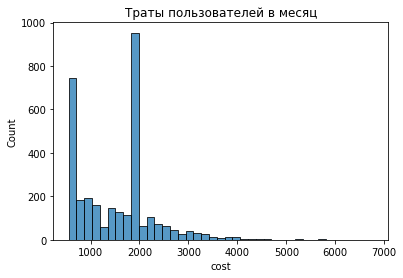

In [40]:
sns.histplot(data=data, x="cost").set_title('Траты пользователей в месяц');

На графике две моды: обе соответствуют стоимость тарифов smart (550 руб.) и ultra (1950 руб.).

Основная сумма трат - до 2000 руб.

In [41]:
# Откроем ящик с усами и посмотрим на выбросы
#data.boxplot('cost').set_title('Траты пользователей в месяц');

Теперь посмотрим внутри каждого тарифа:

In [42]:
# Посмотрим на разность тарифов

print(data_tariff_smart['cost'].describe())
print()
print(data_tariff_ultra['cost'].describe())

count    2229.000000
mean     1289.973531
std       818.404367
min       550.000000
25%       550.000000
50%      1023.000000
75%      1750.000000
max      6770.000000
Name: cost, dtype: float64

count     985.000000
mean     2070.152284
std       376.187114
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: cost, dtype: float64


В smart медиана в два раза выше абон. платы. Это говорит о том, что пользователи smart активно платят за превышение лимита.

В ultra центр нормального распределение - в рамках абон. платы.

In [43]:
# Суммарная выручка
print('smart суммарная:', data_tariff_smart['cost'].sum())
print('ultra суммарная:', data_tariff_ultra['cost'].sum())

smart суммарная: 2875351.0
ultra суммарная: 2039100.0


Суммарно тариф smart в выборке приносит больше денег, несмотря на то что абон. плата ниже. В т.ч. за месяц.

In [44]:
# Кто приносит больше выручки в месяц

print('Выручка smart в месяц:', data_tariff_smart.pivot_table(index='month', values='cost', aggfunc='sum')['cost'].mean())
print('Выручка ultra в месяц:', data_tariff_ultra.pivot_table(index='month', values='cost', aggfunc='sum')['cost'].mean())

Выручка smart в месяц: 239612.58333333334
Выручка ultra в месяц: 169925.0


In [45]:
print('Выручка smart в месяц на пользователя:', data_tariff_smart.pivot_table(index=['user_id', 'month'], values='cost', aggfunc='sum')['cost'].mean())
print('Выручка ultra в месяц на пользователя:', data_tariff_ultra.pivot_table(index=['user_id', 'month'], values='cost', aggfunc='sum')['cost'].mean())

Выручка smart в месяц на пользователя: 1289.9735307312696
Выручка ultra в месяц на пользователя: 2070.1522842639592


Выручка ultra на пользователя в месяц гораздо больше: 2070 руб. против 1290 руб.

In [46]:
# Считаем дисперсию выборки и std

print('smart cost дисперсия: ', np.var(data_tariff_smart['cost'], ddof=1))
print('smart cost std: ', np.sqrt(np.var(data_tariff_smart['cost'], ddof=1)))

print('ultra cost дисперсия: ', np.var(data_tariff_ultra['cost'], ddof=1))
print('ultra cost std: ', np.sqrt(np.var(data_tariff_ultra['cost'], ddof=1)))

# Знаю, что можно юзать np.std или посмотреть describe, но решил так, чтобы закрепить, что это кв. корень.

smart cost дисперсия:  669785.7080064242
smart cost std:  818.4043670499469
ultra cost дисперсия:  141516.7450786183
ultra cost std:  376.1871144505328


В ultra разброс выручка в два раза меньше.

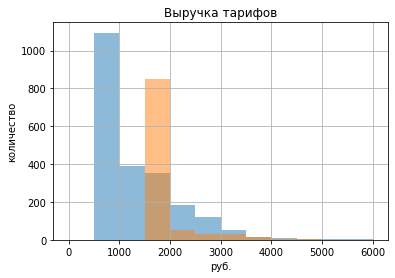

In [47]:
ax = data_tariff_smart['cost'].hist(bins=[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 6000], alpha=0.5);
ax2 = data_tariff_ultra['cost'].hist(bins=[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 6000], alpha=0.5);

ax.set_title('Выручка тарифов');
ax.set_xlabel('руб.');
ax.set_ylabel('количество');

Посмотрим на округлённые минуты разговора:

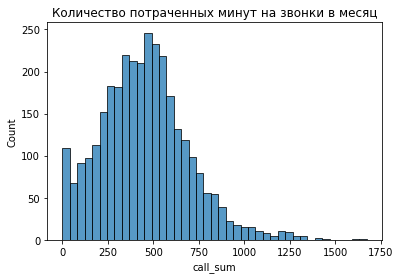

In [48]:
# Звонки
sns.histplot(data=data, x="call_sum").set_title('Количество потраченных минут на звонки в месяц');

Вполне нормально распределение.

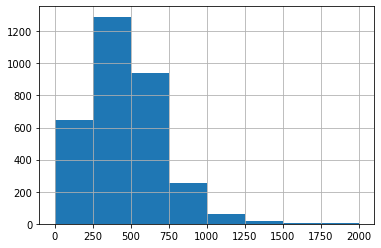

In [49]:
# Посмотрим на минуты с помощью гистограммы плотности
data['call_sum'].hist(bins=[0, 250, 500, 750, 1000, 1250, 1500, 2000]);

In [50]:
data['call_sum'].describe()

count    3214.000000
mean      451.244866
std       241.909978
min         0.000000
25%       282.000000
50%       443.000000
75%       589.000000
max      1673.000000
Name: call_sum, dtype: float64

В среднем пользователи тратят 443 минуты (медиана) - это около 7 часов разговоров. Ноль минут - это пропущенные звонки.

Большинство пользователей тратит на разговоры от 280 до 580 минут в месяц.

Статистика по звонкам внутри тарифов:

In [51]:
# Посмотрим на разность тарифов

print(data_tariff_smart['call_sum'].describe())
print()
print(data_tariff_ultra['call_sum'].describe())

count    2229.000000
mean      417.934948
std       190.313730
min         0.000000
25%       282.000000
50%       422.000000
75%       545.000000
max      1435.000000
Name: call_sum, dtype: float64

count     985.000000
mean      526.623350
std       317.606098
min         0.000000
25%       284.000000
50%       518.000000
75%       752.000000
max      1673.000000
Name: call_sum, dtype: float64


В ultra не превышают лимит в 3000, в отличие от smart, но тратят в среднем больше времени на разговоры (518 против 422 минут).

В smart в среднем не превышают лимит в 500 минут.

В ultra больше разброс (std) между месяцами. 

In [52]:
# Считаем дисперсию выборки и std

print('smart call_sum_min дисперсия: ', np.var(data_tariff_smart['call_sum'], ddof=1))
print('smart call_sum_min std: ', np.std(data_tariff_smart['call_sum']))

print('ultra call_sum_min дисперсия: ', np.var(data_tariff_ultra['call_sum'], ddof=1))
print('ultra call_sum_min std: ', np.std(data_tariff_ultra['call_sum']))

smart call_sum_min дисперсия:  36219.31578434428
smart call_sum_min std:  190.27103471651876
ultra call_sum_min дисперсия:  100873.63339730098
ultra call_sum_min std:  317.44483554974113


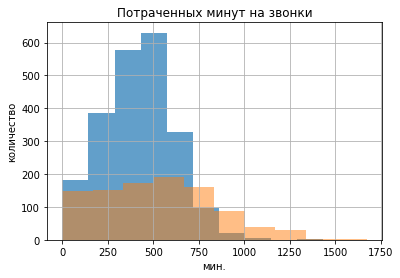

In [53]:
# Посмотрим на минуты с помощью гистограммы плотности
ax = data_tariff_smart['call_sum'].hist(alpha=0.7);
ax2 = data_tariff_ultra['call_sum'].hist(alpha=0.5);

ax.set_title('Потраченных минут на звонки');
ax.set_xlabel('мин.');
ax.set_ylabel('количество');

In [54]:
# Посмотрим как часто превышают лимит
data_tariff_smart.query('call_sum > 500')['user_id'].count() / data_tariff_smart['user_id'].count() * 100

33.82682817406909

В 33% случаев пользователи тарифа Smart превышают месячный лимит и доплачивают за минуты.

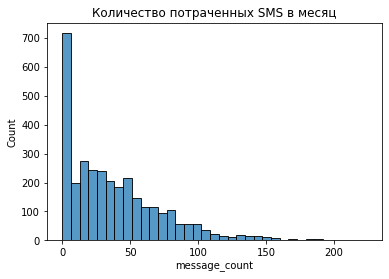

In [55]:
# СМС
sns.histplot(data=data, x="message_count").set_title('Количество потраченных SMS в месяц');

Получили распределение Пуассона. Мода на 0 - много тех, кто не отправляют смски.


In [56]:
data['message_count'].describe()

count    3214.000000
mean       38.281269
std        36.148326
min         0.000000
25%         9.000000
50%        30.000000
75%        57.000000
max       224.000000
Name: message_count, dtype: float64

В среднем пользователи отправляют 30 сообщений (медиана) в месяц. 

In [57]:
# Посмотрим на разность тарифов

print(data_tariff_smart['message_count'].describe())
print()
print(data_tariff_ultra['message_count'].describe())

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: message_count, dtype: float64

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: message_count, dtype: float64


In [58]:
# Считаем дисперсию выборки и std

print('smart message_count дисперсия: ', np.var(data_tariff_smart['message_count'], ddof=1))
print('smart message_count std: ', np.std(data_tariff_smart['message_count']))

print('ultra message_count дисперсия: ', np.var(data_tariff_ultra['message_count'], ddof=1))
print('ultra message_count std: ', np.std(data_tariff_ultra['message_count']))

smart message_count дисперсия:  796.8129584480083
smart message_count std:  28.221542886898938
ultra message_count дисперсия:  2285.2661425446736
ultra message_count std:  47.78018496610161


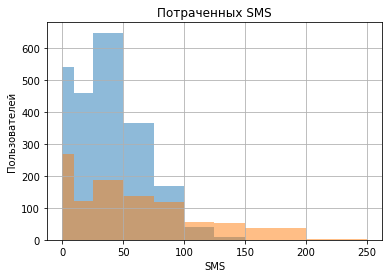

In [59]:
# Посмотрим на SMS с помощью гистограммы плотности
ax = data_tariff_smart['message_count'].hist(bins=[0, 10, 25, 50, 75, 100, 125, 150, 200, 250], alpha=0.5);
ax2 = data_tariff_ultra['message_count'].hist(bins=[0, 10, 25, 50, 75, 100, 125, 150, 200, 250], alpha=0.5);

ax.set_title('Потраченных SMS');
ax.set_xlabel('SMS');
ax.set_ylabel('Пользователей');

In [60]:
# Посмотрим какой процент в smart превышает лимит SMS
data_tariff_smart.query('message_count > 50')['user_id'].count() / data_tariff_smart['message_count'].count() * 100

25.3028263795424

На графике в тарифе "ultra" видна мода на нулевом значении, т.е. немалое количество людей на этом тарифе не пользуются SMS.

Но в среднем, в ultra отправляют больше sms: 38 против 28. Это видно также на графике, в диапазоне от 100 до 200 сообщений. Максимум - 224 сообщения, планку в 1000 никто не достигает.

В smart, в 25% случаев превышают лимит SMS и доплачивают за сообщения.

Разброс в ultra по sms больше: 47 против 28


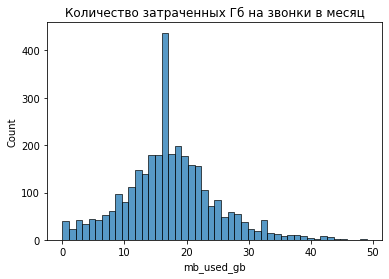

In [61]:
# Траты на интернет с уже округлёнными значениями
sns.histplot(data=data, x="mb_used_gb").set_title('Количество затраченных Гб на звонки в месяц');

In [62]:
data['mb_used_gb'].mode()

0    17.0
dtype: float64

График имеет вид нормального распределения. Отчётливая мода на графике - 17 Гб.

In [63]:
data['mb_used_gb'].describe()

count    3214.000000
mean       17.299004
std         7.400584
min         0.000000
25%        13.000000
50%        17.000000
75%        21.000000
max        49.000000
Name: mb_used_gb, dtype: float64

In [64]:
# Посмотрим на разность тарифов

print(data_tariff_smart['mb_used_gb'].describe())
print()
print(data_tariff_ultra['mb_used_gb'].describe())

count    2229.000000
mean       16.328847
std         5.747061
min         0.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        38.000000
Name: mb_used_gb, dtype: float64

count    985.000000
mean      19.494416
std        9.853511
min        0.000000
25%       12.000000
50%       19.000000
75%       27.000000
max       49.000000
Name: mb_used_gb, dtype: float64


В ultra в среднем используют больше трафика: 19 Гб против 17 Гб. 

In [65]:
# Сколько превышают лимит в Smart и Ultra
print('В smart:', data_tariff_smart.query('mb_used_gb > 15')['user_id'].count() / data_tariff_smart['user_id'].count() * 100)
print('В ultra:', data_tariff_ultra.query('mb_used_gb > 30')['user_id'].count() / data_tariff_ultra['user_id'].count() * 100)

В smart: 58.50157021085689
В ultra: 13.604060913705585


Пользователи всех тарифов превышают месячный лимит тарифа. В smart больше половины - 58%. В ultra всего лишь 13%.

In [66]:
# Сколько в ultra превысили 15гб лимита
data_tariff_ultra.query('mb_used_gb > 15')['user_id'].count() / data_tariff_ultra['user_id'].count() * 100

64.46700507614213

Если бы пользователи ultra перешли бы в smart, то в 64% случаев они превышали бы лимит в 15 Гб.

In [67]:
# Считаем дисперсию выборки и std

print('smart mb_used_gb дисперсия: ', np.var(data_tariff_smart['mb_used_gb'], ddof=1))
print('smart mb_used_gb std: ', np.std(data_tariff_smart['mb_used_gb']))

print('ultra mb_used_gb дисперсия: ', np.var(data_tariff_ultra['mb_used_gb'], ddof=1))
print('ultra mb_used_gb std: ', np.std(data_tariff_ultra['mb_used_gb']))

smart mb_used_gb дисперсия:  33.02870517811161
smart mb_used_gb std:  5.745771267187499
ultra mb_used_gb дисперсия:  97.09168626965459
ultra mb_used_gb std:  9.848508314957495


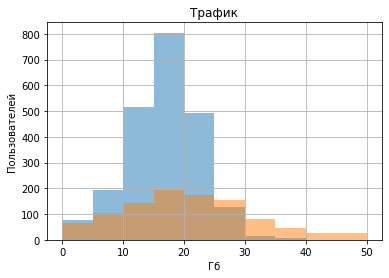

In [68]:
# Посмотрим на Интернет с помощью гистограммы плотности
ax = data_tariff_smart['mb_used_gb'].hist(bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 50], alpha=0.5);
ax = data_tariff_ultra['mb_used_gb'].hist(bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 50], alpha=0.5);

ax.set_title('Трафик');
ax.set_xlabel('Гб');
ax.set_ylabel('Пользователей');

**Выводы:**

* Созданые два датафрейма со срезами данных по тарифам.


* **Выводы по выручке**:
* Медиана - 1653 руб. за месяц. Максимальная сумма - 6770 руб., а минимальная на уровне стоимость тарифа - 550 руб.
* На графике две моды: обе соответствуют стоимость тарифов smart (550 руб.) и ultra (1950 руб.). Основная сумма трат - до 2000 руб.
* В smart медиана в два раза выше абон. платы. Это говорит о том, что пользователи smart активно платят за превышение лимита.
В ultra центр нормального распределение - в рамках абон. платы.
* Суммарно тариф smart в выборке приносит больше денег, несмотря на то что абон. плата ниже. В т.ч. за месяц.
* Выручка ultra на пользователя в месяц гораздо больше: 2070 руб. против 1290 руб.
* В ultra разброс выручка в два раза меньше.
    
    
* **Выводы по звонкам**:
* В среднем пользователи тратят 443 минуты (медиана) - это около 7 часов разговоров. Ноль минут - это пропущенные звонки.
Большинство пользователей тратит на разговоры от 280 до 580 минут в месяц.
* В ultra не превышают лимит в 3000, в отличие от smart, но тратят в среднем больше времени на разговоры (518 против 422 минут).
* В smart в среднем не превышают лимит в 500 минут.
* В ultra больше разброс (std) между месяцами.
* В 33% случаев пользователи тарифа Smart превышают месячный лимит и доплачивают за минуты.
* Получили распределение Пуассона. Мода на 0 - много тех, кто не отправляют смски.
* В среднем пользователи отправляют 30 сообщений (медиана) в месяц.


* **Выводы по сообщениям**:
* График имеет вид распределения Пуассона. Мода в графике на 0 - большое количество пользователей, кот. не отправляют смс.
* В среднем пользователи отправляют 30 сообщений (медиана) в месяц.
* На графике в тарифе "ultra" видна мода на нулевом значении, т.е. немалое количество людей на этом тарифе не пользуются SMS.
* Но в среднем, в ultra отправляют больше sms: 38 против 28. Это видно также на графике, в диапазоне от 100 до 200 сообщений. Максимум - 224 сообщения, планку в 1000 никто не достигает.
* В smart, в 25% случаев превышают лимит SMS и доплачивают за сообщения.
* Разброс в ultra по sms больше: 47 против 28


* **Выводы по трафику**:
* График имеет вид нормального распределения. Отчётливая мода на графике - 17 Гб.
* В ultra в среднем используют больше трафика: 19 Гб против 17 Гб.
* Пользователи всех тарифов превышают месячный лимит тарифа. В smart больше половины - 58%. В ultra всего лишь 13%.
* Если бы пользователи ultra перешли бы в smart, то в 64% случаев они превышали бы лимит в 15 Гб.

### Шаг 4. Проверка гипотез
<a id='level4'></a>

Гипотезы:

* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Возьмём первую гипотезу. 

Нулевая гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются. 

Альтернативная гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. 

In [69]:
# Установим параметр чувствительности поменьше - в 0.01%
alpha = .01

# Выключаем equal_var, т.к. количество строк разные и дисперсия тоже
results = st.ttest_ind(
    data_tariff_smart['cost'], 
    data_tariff_ultra['cost'], 
    equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


Итог: Не отвергаем нулевую гипотезу - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. Даже если повысим пороговое значение.

**Вторая гипотеза**

Нулевая гипотеза: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

Альтернативная гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. 

In [70]:
# Сделаем срез данных по гео
data_msc = data.query('city == "Москва"')
data_regions = data.query('city != "Москва"')

alpha = .05

# Здесь тоже выключим equal_var - выборки разные по размеру
results = st.ttest_ind(
    data_msc['cost'], 
    data_regions['cost'], 
    equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
    
print('Москва:', data_msc['cost'].median())
print('Регионы:', data_regions['cost'].median())

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу
Москва: 1750.0
Регионы: 1583.0


Нулевую гипотезу не удалось отвергнуть.

Полученное значение p-value говорит о том, что хотя средний чек в регионах разный, с вероятностью в почти 52% такое или большее различие можно получить случайно. Это очень большая вероятность, чтобы делать вывод о значимом различии между средними чеками.

Пороговое значение на результат не влияет.

In [71]:
# Приведены два датасета: сумма покупок, совершённых за месяц посетителями ...

sample_1 = [3071, 3636, 3454, 3151, 2185, 3259, 1727, 2263, 2015,
2582, 4815, 633, 3186, 887, 2028, 3589, 2564, 1422, 1785,
3180, 1770, 2716, 2546, 1848, 4644, 3134, 475, 2686,
1838, 3352]
sample_2 = [1211, 1228, 2157, 3699, 600, 1898, 1688, 1420, 5048, 3007,
509, 3777, 5583, 3949, 121, 1674, 4300, 1338, 3066,
3562, 1010, 2311, 462, 863, 2021, 528, 1849, 255,
1740, 2596]
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
sample_1,
sample_2)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:

    print("Не получилось отвергнуть нулевую гипотезу")
    

p-значение: 0.1912450522572209
Не получилось отвергнуть нулевую гипотезу


## Общие выводы

* Изначально было мало ошибок в данных и отсутствовали пропущенные значения, дубликаты. Была выполнена проверка на дубликаты категориальных значений.
* Возраст пользователей начинается с 18 лет. Основной возраст - от 18 до 62 лет. Пик графика на возрасте 46 лет. Вторая мода на уровне 26-28 лет. Самому старому клиенту 75 лет.
* Были произведены расчёт по пользователям и месяцам. Получили таблицу с суммой звонков, сообщений, трафика, выручки, где индексами были - id юзера и месяц. А значение - сумма за месяц.
* В тарифе smart едиана в два раза выше от абонентской платы и составляет 1023 руб. Значит пользователи этого тарифа больше платят за превышение лимита. Это видно по стандартному отклонению. В smart = 818 руб. Ultra = 376 руб.
* Средняя выручка (медиана) за месяц в ultra больше: 1950 руб. против 1023 руб.
* Суммарная выручка в smart, в выборке, больше почти на 800 т.р. Соотношение с выручкой в месяц примерно такое же.
* В среднем, в ultra отправляют больше sms: 38 против 28.
* В smart, в 25% случаев превышают лимит SMS и доплачивают за сообщения.
* В Smart гораздо чаще превышают лимит тариф на трафик - в 58% случаев. В ultra лишь в 13%.
* В Ultra, в среднем тратят на 2Гб больше трафика. 64% пользователей ultra превышают лимит 15 гб, кот. у smart. Можно сказать, что пользователи ultra пользуются, в большей степени, расширенным лимитом трафика, чем звонками и смс.
* Были проверены две гипотезы. Результаты: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. А средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов

**Выводы по сравнению выручек:**

* Smart суммарно принесла больше денег в выборке: **2 875 351 руб.** против **2 039 100 руб.**
* Выручка ultra в месяц: **239 612** руб. Smart: **169 925** руб.
* Выручка smart в месяц на пользователя: **1290 руб.** Выручка ultra в месяц на пользователя: **2070 руб.**

* Smart в выборке принесла больше денег, несмотря на то что абон. плата в ultra выше. Компании выгоднее оставлять пользователей на тарифе smart и брать экстра-оплату. Либо предлагать перейти на ultra, если важна лояльность, а не выручка компании.